# Aggregating Slice Results

In this report, I will explore different ways of aggregating slice classification results, in order to evaluate fibrosis presence in patient, rather than individual slices.

This notebook already uses the optimization methods tested in `3.2 - pureVsConservative`:

 - resize before augmentations 
 - pure lowest validation loss value model choice

In [10]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from scipy.ndimage import gaussian_filter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import albumentations as A
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import random
import copy
import os


# ------------ Utils ------------

from aggregateUtils import * 

# -----------  ResNet -----------

# Core library
import torch

# Essentials for development
import torch.nn as nn
from torchsummary import summary
import torchvision.models as models
from torchvision.models import ResNet18_Weights

# Data resize (ResNet uses (224,224) inputs)
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

# Allows for paralell batch processing
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import decode_image

In [18]:
print(torch.cuda.is_available())          
print(torch.cuda.get_device_name(0))     

for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

True
NVIDIA GeForce RTX 3070
Device 0: NVIDIA GeForce RTX 3070


In [11]:
# Loads the dataframe
df_fibrosis = pd.read_pickle(r'..\..\..\\fibrosis_data.pkl')

In [12]:
df_annotations = df_fibrosis.drop(columns="SliceData")
df_annotations["SliceID"] = df_annotations["SliceID"].astype(str) + ".npy" # better for data loader
df_annotations.head()

,SliceID,Class
0,101__CT-0002-0001.npy,0
1,101__CT-0002-0002.npy,0
2,101__CT-0002-0003.npy,0
3,101__CT-0002-0004.npy,0
4,101__CT-0002-0005.npy,0


In [13]:
class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # idx represents index
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])

        # Load the .npy file
        image = np.load(img_path)
        
        #image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        # Adds random set of augmentations
        if self.albumentations:
            # Applies resize prior to augmentations
            # Could hinder scan quality, but drastically improves training speed
            resize = transforms.Resize((224, 224))
            image = resize(image)
            augmented = self.albumentations(image=image)
            image = augmented['image']

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
            # Gaussian Blur
            gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
            # Random choice
            image = random.choice((gauss_noise,gauss_blur))

        # Guarantee compatibility
        if self.gauss or self.albumentations: image = image.astype(np.float32)

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

All of the train-test-validation splits were previously doccumented and performed in `2 - testSplit`:

## Training

In [20]:
def trainResNet(train_dataset, val_dataset, num_epochs=90, batch_size=32, lr=5e-7, patience=5, improve_min=0.001):
    # New ResNet instance
    resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

    # Considers only absolute lowest val_loss value
    best_model_pure = copy.deepcopy(resnet18)
    best_val_pure, epoch_pure = 10, 0

    # Use only 2 output neurons
    num_ftrs = resnet18.fc.in_features
    resnet18.fc = nn.Linear(num_ftrs, 2)  

    # If graphics card is available, uses it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet18.to(device)

    print("*"+("-"*29)+"*")
    print("|{:^29}|".format(f"Using {device}"))
    print("*"+("-"*29)+"*")

    # Generate data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Loss function 
    criterion = nn.CrossEntropyLoss()  
    # ADAM
    optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr)

    # add learning_rate_scheduler e step learning rate

    # Initializing early stop counter (based on validation loss)
    best_loss = 10
    early_stop_ctr = 0

    loss_array = []
    val_loss_array = []


    for epoch in range(num_epochs):
        resnet18.train()
        running_loss = 0.0
        running_val_loss = 0.0


        # --------------- Weight updates ---------------
        
        # Iterates over each image in dataset, updates weights
        for images, labels in tqdm((train_loader), desc = "Training..."):
            images, labels = images.to(device), labels.to(device)
            
            # Applies ADAM 
            optimizer.zero_grad()

            # Generates output
            outputs = resnet18(images)

            # Computes loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Computes average training loss
        avg_loss_train = running_loss/len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {avg_loss_train:.6f}")
        loss_array.append(avg_loss_train)


        # ---------------- Validation Loss -----------------

        # Iterates over each image in dataset, computes validation loss
        for images, labels in (val_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Applies ADAM 
            optimizer.zero_grad()

            # Generates output
            outputs = resnet18(images)

            # Computes loss
            val_loss = criterion(outputs, labels)
            
            running_val_loss += val_loss.item()

        # Computes average validation loss
        avg_loss_val = running_val_loss/len(val_loader)
        print(f"Validation loss: {avg_loss_val:.6f}")
        val_loss_array.append(avg_loss_val)


        # ------------------ Best Model -------------------

        if epoch >= 35:
            if avg_loss_val < best_val_pure:
                best_val_pure = avg_loss_val
                best_model_pure = copy.deepcopy(resnet18)
                epoch_pure = epoch
        
        
        # ---------------- Early Stopping -----------------

        # Only after a high number of epochs (around 60)
        if epoch > 60:
            # Check for improvement (1% standard)
            if abs(best_loss - avg_loss_val) > (best_loss * improve_min):
                best_loss = avg_loss_val
                early_stop_ctr = 0
            else: early_stop_ctr += 1

            # Checks early stopping condition
            if early_stop_ctr >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs!!!")
                break
    
    return best_model_pure, epoch_pure, loss_array, val_loss_array

In [ ]:
# Paths
img_dir = r'..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestHRCT\train_hrct.csv"
annotations_file_test = r"..\trainTestHRCT\test_hrct.csv"
annotations_file_val = r"..\trainTestHRCT\val_hrct.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Augmentations
augment = A.Compose([
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)

In [ ]:
models_path = "..\\..\\..\\trainedResNets\\aggregateProb\\"
os.makedirs(models_path, exist_ok=True)

ans = str(input("Do you wish to run or read?"))

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    # Read from images
    pass

    
else: print("Invalid answer, try again.")

C:\Users\hasht\AppData\Local\Temp\ipykernel_4888\267352167.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_hrct = torch.load((f"{models_path}"+"resnet_hrct.pkl")

In [ ]:
ans = str(input("Do you wish to save?"))

if ans == "yes": 
    torch.save({
    'model_state_dict': resnet_eval.state_dict(),
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'resnet_aggregate.pt'))

else: print("DID NOT SAVE")

DID NOT SAVE


# Results and Aggregation Methods

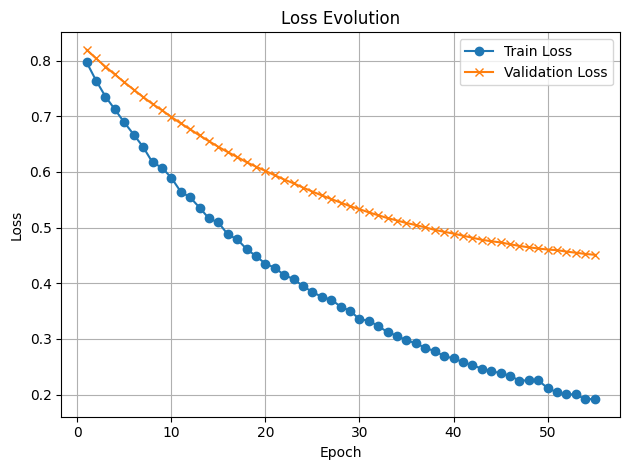

In [ ]:
plotLoss(hrct_loss, hrct_val_loss, best_epoch)

In [21]:
def evalResNet(resnet18, test_dataset, threshold, auc):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Counters for each class
    correct, total = 0, 0
    correct_class_0, total_class_0 = 0, 0
    correct_class_1, total_class_1 = 0, 0

    # Needed for F1 score and confusion matrix
    y_true = []
    y_pred = []


    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Transform outputs to probabilities
            outputs = resnet18(images)

            # Translate logits to Class 1 probabilities using softmax
            probs = F.softmax(outputs, dim=1)[:, 1] 

            # Translate prob vs threshold to predictions
            # True if prob >= threshold else False
            # .long() transforms True/False to 1/0
            predicted = (probs >= threshold).long()
            
            # Update total and correct for general accuracy
            total += labels.size(0)

            correct += (predicted == labels).sum().item()

            # Class-specific accuracy
            for label, pred in zip(labels, predicted):
                if label == 0:
                    total_class_0 += 1
                    if pred == label:
                        correct_class_0 += 1
                elif label == 1:
                    total_class_1 += 1
                    if pred == label:
                        correct_class_1 += 1

            # Add data to lists
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(predicted.cpu().tolist())



    # Weights == inverse proportions
    weight_0, weight_1 = 0.133, 0.867

    print("Total examples:", total)

    # -------------------------------     Perfomance Metrics     -------------------------------

    # Accuracy
    accuracy_class_0 = 100 * (correct_class_0 / total_class_0) if total_class_0 > 0 else 0
    accuracy_class_1 = 100 * (correct_class_1 / total_class_1) if total_class_1 > 0 else 0
    accuracy = 100 * (correct / total)
    accuracy2 = 100 * ((correct_class_0 + correct_class_1) / total)
    weighted_accuracy = ((accuracy_class_0*weight_0) + (accuracy_class_1*weight_1))

    # F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro') # Assigns same importance to each class
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_class_0 = f1_score(y_true, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_true, y_pred, pos_label=1)

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred)


    # -------------------------------     Print Results     -------------------------------

    # Accuracy
    print("\n --------------------- \n")
    print(f"Accuracy for Class 0: {accuracy_class_0:.2f}%  ({correct_class_0} in {total_class_0})")
    print(f"Accuracy for Class 1: {accuracy_class_1:.2f}%  ({correct_class_1} in {total_class_1})")
    print(f"Test Accuracy: {accuracy:.2f}%")
    if f"{accuracy:.2f}" != f"{accuracy2:.2f}": print("ERROR CALCULATING ACCURACIES")
    print(f"Weighted Accuracy: {weighted_accuracy:.2f}%")

    # AUC
    print("\n --------------------- \n")
    print("Area Under Curve:", auc)

    # F1 scores
    print("\n --------------------- \n")
    print(f"F1 Score (Macro): {f1_macro:.3f}")
    print(f"F1 Score (Weighted): {f1_weighted:.3f}")
    print(f"F1 Score Class 0: {f1_class_0:.3f}")
    print(f"F1 Score Class 1: {f1_class_1:.3f}")

    # Confusion matrix
    print("\n --------------------- \n")
    print("\nConfusion Matrix: \n", conf_mat)

In [22]:
evalResNet(resnet_hrct, test_dataset,threshold_hrct,auc_hrct)

Total examples: 301

 --------------------- 

Accuracy for Class 0: 80.61%  (237 in 294)
Accuracy for Class 1: 57.14%  (4 in 7)
Test Accuracy: 80.07%
Weighted Accuracy: 60.26%

 --------------------- 

Area Under Curve: 0.788676588897828

 --------------------- 

F1 Score (Macro): 0.503
F1 Score (Weighted): 0.870
F1 Score Class 0: 0.888
F1 Score Class 1: 0.118

 --------------------- 


Confusion Matrix: 
 [[237  57]
 [  3   4]]


SliceID at index 977: 38__CT-0002-0002.npy
(224, 224, 3)


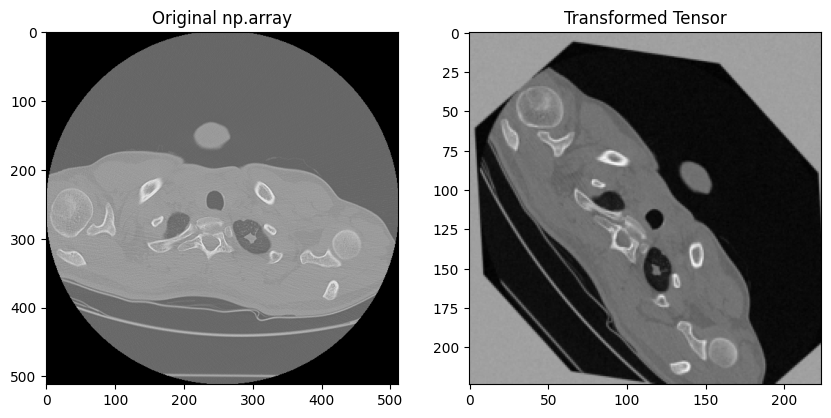

In [31]:
tensorVSnp(train_dataset, False)

In [32]:
models_path = "..\\..\\trainedResNets\\"

ans = str(input("Do you wish to run or read?"))

# Choice execution
if ans == "run": 
    resnet_custom_aug, custom_aug_loss, custom_aug_val_loss = trainResNet(train_dataset,val_dataset,num_epochs=40)

    with open(r'pickleJar\custom_aug_loss.pkl', 'wb') as f:
        pickle.dump(custom_aug_loss, f)

    with open(r'pickleJar\custom_aug_val_loss.pkl', 'wb') as f:
        pickle.dump(custom_aug_val_loss, f)

elif ans == "read": 
    resnet_custom_aug = torch.load((f"{models_path}"+"resnet_custom_aug.pkl"))

    with open(r'pickleJar\custom_aug_loss.pkl', 'rb') as f:
        custom_aug_loss = pickle.load(f)

    with open(r'pickleJar\custom_aug_val_loss.pkl', 'rb') as f:
        custom_aug_val_loss = pickle.load(f)
    

else: print("Invalid answer, try again.")

C:\Users\hasht\AppData\Local\Temp\ipykernel_4888\3662648823.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_custom_aug = torch.load((f"{models_path}"+"resnet_cus

In [166]:
ans = str(input("Do you wish to save?"))

if ans == "yes": torch.save(resnet_custom_aug, (f"{models_path}"+"resnet_custom_aug.pkl"))
else: print("DID NOT SAVE")

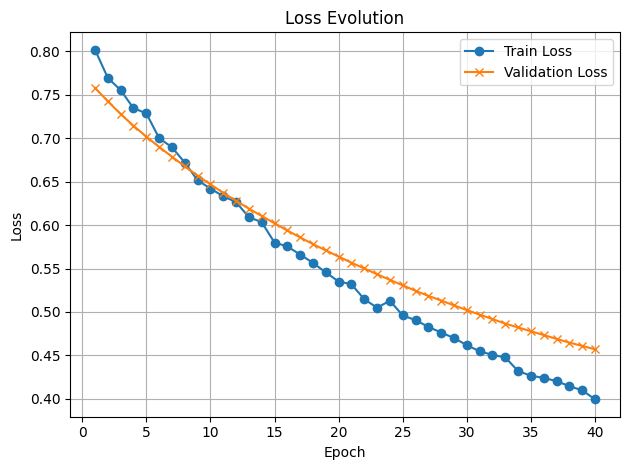

In [35]:
plotLoss(custom_aug_loss, custom_aug_val_loss)

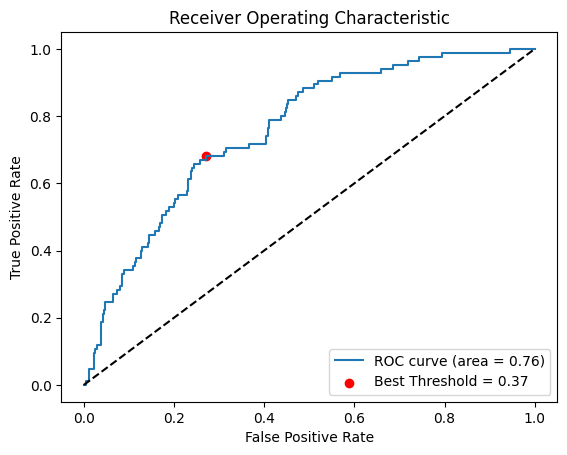

Area Under Curve: 0.7593354926339985
Best Threshold (closest to (0,1)): 0.36896533


In [33]:
threshold_custom_aug, auc_augment = getROC(resnet_custom_aug, val_dataset)

In [34]:
evalResNet(resnet_custom_aug, test_dataset, threshold_custom_aug, auc_augment)

Total examples: 648

 --------------------- 

Accuracy for Class 0: 72.82%  (410 in 563)
Accuracy for Class 1: 68.24%  (58 in 85)
Test Accuracy: 72.22%
Weighted Accuracy: 68.85%

 --------------------- 

Area Under Curve: 0.7593354926339985

 --------------------- 

F1 Score (Macro): 0.606
F1 Score (Weighted): 0.764
F1 Score Class 0: 0.820
F1 Score Class 1: 0.392

 --------------------- 


Confusion Matrix: 
 [[410 153]
 [ 27  58]]


In [169]:
ans = str(input("Do you wish to save models? (WARNING: OVERWRITES!!!)"))

if ans.lower() == 'yes':
    torch.save(resnet_hrct, (f"{models_path}"+"resnet_hrct.pkl"))
    torch.save(resnet_custom, (f"{models_path}"+"resnet_custom.pkl"))
    torch.save(resnet_custom_aug, (f"{models_path}"+"resnet_custom_aug.pkl"))